# Pipeline to compare calibration methods

Here we will compare several calibration methods given a table of experimental results. In the notebook we will explain all the process step by step. At the end of this notebook there is a summary.

In [1]:
%matplotlib inline
%precision 2
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd

We load the results in a Pandas DataFrame, and change the data type to the categorical columns in order to optimize the space in memory.

In [2]:
df_results = pd.read_csv('data/results.csv.zip')

category_list = ['dataset', 'method', 'classifier']
for cat in category_list:
    df_results[cat] = df_results[cat].astype('category')

df_results.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'n_classes', 'n_features',
       'n_samples', 'method', 'mc', 'test_fold', 'train_acc', 'train_loss',
       'train_brier', 'acc', 'loss', 'brier', 'calibrators', 'classifier'],
      dtype='object')

We can see how many datasets, classifiers and calibrators have been used in the experiments

In [3]:
n_datasets = len(df_results['dataset'].cat.categories)
n_classifiers = len(df_results['classifier'].cat.categories)
n_calibrators = len(df_results['method'].cat.categories)
print('Datasets: {}\nClassifiers: {}\nCalibrators: {}'.format(
            n_datasets, n_classifiers, n_calibrators))

Datasets: 21
Classifiers: 11
Calibrators: 9


Here we show some of the content of the DataFrame

In [4]:
df_results

,Unnamed: 0,Unnamed: 0.1,dataset,n_classes,n_features,n_samples,method,mc,test_fold,train_acc,train_loss,train_brier,acc,loss,brier,calibrators,classifier
0,0,0,abalone,3,8,4177,binning_freq,0,0,0.547299,0.864392,0.176453,0.575866,0.843147,0.171863,"[{'estimator': BinningCalibration(alpha=1.0, n...",svc-linear
1,1,1,abalone,3,8,4177,binning_freq,0,1,0.561974,0.854114,0.173836,0.530466,0.884473,0.181226,"[{'estimator': BinningCalibration(alpha=1.0, n...",svc-linear
2,2,2,abalone,3,8,4177,binning_freq,0,2,0.565828,0.848819,0.173540,0.546108,0.877516,0.177199,"[{'estimator': BinningCalibration(alpha=1.0, n...",svc-linear
3,3,3,abalone,3,8,4177,binning_freq,0,3,0.562965,0.854322,0.174269,0.543165,0.878218,0.178944,"[{'estimator': BinningCalibration(alpha=1.0, n...",svc-linear
4,4,4,abalone,3,8,4177,binning_freq,0,4,0.554301,0.867235,0.176645,0.563549,0.841619,0.171342,"[{'estimator': BinningCalibration(alpha=1.0, n...",svc-linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56920,78470,20,iris,3,4,150,uncalibrated,4,0,0.958486,0.084016,0.015747,0.933333,0.136420,0.025967,"[{}, {}, {}]",qda
56921,78471,21,iris,3,4,150,uncalibrated,4,1,0.966422,0.106260,0.019497,1.000000,0.058915,0.007531,"[{}, {}, {}]",qda
56922,78472,22,iris,3,4,150,uncalibrated,4,2,0.974359,0.116668,0.021652,0.966667,0.080573,0.013836,"[{}, {}, {}]",qda
56923,78473,23,iris,3,4,150,uncalibrated,4,3,0.991453,0.066244,0.010291,0.866667,0.149828,0.032383,"[{}, {}, {}]",qda


We can see what datasets we have in the table

In [5]:
df_results['dataset'].cat.categories

Index(['abalone', 'balance-scale', 'car', 'cleveland', 'dermatology', 'glass',
       'iris', 'landsat-satellite', 'libras-movement', 'mfeat-karhunen',
       'mfeat-morphological', 'mfeat-zernike', 'optdigits', 'page-blocks',
       'pendigits', 'segment', 'shuttle', 'vehicle', 'vowel', 'waveform-5000',
       'yeast'],
      dtype='object')

What classifiers

In [6]:
df_results['classifier'].cat.categories

Index(['adas', 'forest', 'knn', 'lda', 'logistic', 'mlp', 'nbayes', 'qda',
       'svc-linear', 'svc-rbf', 'tree'],
      dtype='object')

and what calibrators

In [7]:
df_results['method'].cat.categories

Index(['binning_freq', 'binning_width', 'dirichlet_full_l2',
       'dirichlet_odir_l2', 'isotonic', 'ovr_dir_full', 'temperature_scaling',
       'uncalibrated', 'vector_scaling'],
      dtype='object')

# Selecting an evaluation metric

For the following examples we will focus on Brier score as an evaluation measure. If 

In [8]:
measure = 'brier'
max_is_better = False

# Example for one classifier

Here we perform a statistical test focusing only in one classifier, and comparing all the calibration methods with several datasets.

### Friedman test

First we compute the Friedman test to find if there are significant differences between the calibration methods.

The Friedman test is a non-parametric statistical test that considers only the rankings of $n$ different test attempts (in this case different datasets) to compare $k$ treatments (in this case calibrators).

Here we use the Python library SciPy function [scipy.stats.friedmanchisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html)

Lets see first that for a given classifier, dataset and calibrator we got several experiment repetitions and cross-validation folds evaluated.

In [9]:
df_results[(df_results.classifier == 'logistic') &
           (df_results.method == 'isotonic') & 
           (df_results.dataset == 'iris')]

,Unnamed: 0,Unnamed: 0.1,dataset,n_classes,n_features,n_samples,method,mc,test_fold,train_acc,train_loss,train_brier,acc,loss,brier,calibrators,classifier
17700,17700,0,iris,3,4,150,isotonic,0,0,0.932845,0.166505,0.035659,0.900000,0.362248,0.073346,[{'estimator': IsotonicCalibration(increasing=...,logistic
17701,17701,1,iris,3,4,150,isotonic,0,1,0.924298,0.173861,0.037834,0.966667,0.098940,0.017017,[{'estimator': IsotonicCalibration(increasing=...,logistic
17702,17702,2,iris,3,4,150,isotonic,0,2,0.932845,0.168747,0.036144,0.833333,0.307068,0.066407,[{'estimator': IsotonicCalibration(increasing=...,logistic
17703,17703,3,iris,3,4,150,isotonic,0,3,0.923077,0.179579,0.039678,0.900000,1.366805,0.065653,[{'estimator': IsotonicCalibration(increasing=...,logistic
17704,17704,4,iris,3,4,150,isotonic,0,4,0.923687,0.160499,0.034073,0.933333,0.210866,0.040032,[{'estimator': IsotonicCalibration(increasing=...,logistic
17705,17705,5,iris,3,4,150,isotonic,1,0,0.925519,0.162540,0.035351,0.900000,2.497747,0.073446,[{'estimator': IsotonicCalibration(increasing=...,logistic
17706,17706,6,iris,3,4,150,isotonic,1,1,0.918193,0.177168,0.037743,0.933333,0.208305,0.039461,[{'estimator': IsotonicCalibration(increasing=...,logistic
17707,17707,7,iris,3,4,150,isotonic,1,2,0.901709,0.184923,0.040898,1.000000,0.097157,0.015442,[{'estimator': IsotonicCalibration(increasing=...,logistic
17708,17708,8,iris,3,4,150,isotonic,1,3,0.919414,0.174103,0.037548,0.933333,0.150076,0.028809,[{'estimator': IsotonicCalibration(increasing=...,logistic
17709,17709,9,iris,3,4,150,isotonic,1,4,0.958486,0.129761,0.025851,0.800000,0.554397,0.113781,[{'estimator': IsotonicCalibration(increasing=...,logistic


We start by selecting one of the classifiers, and retrieve all the previously choosen averaged measure for each datased and calibrator.

In [10]:
classifier_name = 'logistic'

class_mask = df_results['classifier'] == classifier_name
table = df_results[class_mask].pivot_table(index=['dataset'],
                                   columns=['method'],
                                   values=[measure],
                                   aggfunc=np.mean)

table

brier                                  \
method              binning_freq binning_width dirichlet_full_l2   
dataset                                                            
abalone                 0.176019      0.175924          0.174878   
balance-scale           0.059815      0.052221          0.041847   
car                     0.094582      0.093994          0.098590   
cleveland               0.106759      0.104583          0.100095   
dermatology             0.029765      0.009640          0.008386   
glass                   0.095501      0.088974          0.087108   
iris                    0.075438      0.065832          0.022792   
landsat-satellite       0.039551      0.038953          0.033002   
libras-movement         0.045458      0.032511          0.029546   
mfeat-karhunen          0.011449      0.008754          0.008128   
mfeat-morphological     0.036687      0.035523          0.032032   
mfeat-zernike           0.023800      0.021756          0.020962   
optdigits               0.007492      0.005990          0.005443   
page-blocks             0.014992      0.013469          0.012821   
pendigits               0.012183      0.011478          0.008602   
segment                 0.021932      0.018960          0.012149   
shuttle                 0.010624      0.009339          0.006626   
vehicle                 0.077751      0.074463          0.070736   
vowel                   0.056923      0.053797          0.040279   
waveform-5000           0.060998      0.060708          0.060094   
yeast                   0.057690      0.055271          0.054806   

                                                              \
method              dirichlet_odir_l2  isotonic ovr_dir_full   
dataset                                                        
abalone                      0.174878  0.175860     0.175690   
balance-scale                0.042090  0.051415     0.052335   
car                          0.098605  0.094335     0.095239   
cleveland                    0.100073  0.101708     0.100564   
dermatology                  0.007961  0.007721     0.007599   
glass                        0.089367  0.084736     0.084973   
iris                         0.023002  0.055080     0.054856   
landsat-satellite            0.033006  0.038539     0.039301   
libras-movement              0.027205  0.026241     0.027232   
mfeat-karhunen               0.008744  0.008269     0.008182   
mfeat-morphological          0.032312  0.034245     0.034851   
mfeat-zernike                0.020943  0.021341     0.021152   
optdigits                    0.005597  0.005821     0.005785   
page-blocks                  0.012914  0.013143     0.013326   
pendigits                    0.008491  0.011338     0.011430   
segment                      0.012235  0.018079     0.018674   
shuttle                      0.006589  0.009677     0.012472   
vehicle                      0.070492  0.073644     0.072862   
vowel                        0.037434  0.051797     0.053038   
waveform-5000                0.060064  0.060472     0.060287   
yeast                        0.054320  0.054762     0.054679   

                                                                     
method              temperature_scaling uncalibrated vector_scaling  
dataset                                                              
abalone                        0.176273     0.176536       0.176380  
balance-scale                  0.056415     0.057924       0.048726  
car                            0.099551     0.099265       0.099425  
cleveland                      0.102363     0.101770       0.100621  
dermatology                    0.006898     0.010913       0.008188  
glass                          0.087139     0.089527       0.085657  
iris                           0.055384     0.072094       0.043607  
landsat-satellite              0.040586     0.042193       0.039599  
libras-movement                0.029117     0.035942       0.027898  
mfeat-karhunen   

We delete any dataset for which at least one method does not have a valid resuls. This is done because the experiments are run simultaneously and some of them could be still running.

In [11]:
table = table[~table.isna().any(axis=1)]

We also change the sign of the metric if a larger value is better, given that we want the best methods to have lower rankings (this is done for the critical difference below).

In [12]:
if max_is_better:
    table *= -1
    
table

brier                                  \
method              binning_freq binning_width dirichlet_full_l2   
dataset                                                            
abalone                 0.176019      0.175924          0.174878   
balance-scale           0.059815      0.052221          0.041847   
car                     0.094582      0.093994          0.098590   
cleveland               0.106759      0.104583          0.100095   
dermatology             0.029765      0.009640          0.008386   
glass                   0.095501      0.088974          0.087108   
iris                    0.075438      0.065832          0.022792   
landsat-satellite       0.039551      0.038953          0.033002   
libras-movement         0.045458      0.032511          0.029546   
mfeat-karhunen          0.011449      0.008754          0.008128   
mfeat-morphological     0.036687      0.035523          0.032032   
mfeat-zernike           0.023800      0.021756          0.020962   
optdigits               0.007492      0.005990          0.005443   
page-blocks             0.014992      0.013469          0.012821   
pendigits               0.012183      0.011478          0.008602   
segment                 0.021932      0.018960          0.012149   
shuttle                 0.010624      0.009339          0.006626   
vehicle                 0.077751      0.074463          0.070736   
vowel                   0.056923      0.053797          0.040279   
waveform-5000           0.060998      0.060708          0.060094   
yeast                   0.057690      0.055271          0.054806   

                                                              \
method              dirichlet_odir_l2  isotonic ovr_dir_full   
dataset                                                        
abalone                      0.174878  0.175860     0.175690   
balance-scale                0.042090  0.051415     0.052335   
car                          0.098605  0.094335     0.095239   
cleveland                    0.100073  0.101708     0.100564   
dermatology                  0.007961  0.007721     0.007599   
glass                        0.089367  0.084736     0.084973   
iris                         0.023002  0.055080     0.054856   
landsat-satellite            0.033006  0.038539     0.039301   
libras-movement              0.027205  0.026241     0.027232   
mfeat-karhunen               0.008744  0.008269     0.008182   
mfeat-morphological          0.032312  0.034245     0.034851   
mfeat-zernike                0.020943  0.021341     0.021152   
optdigits                    0.005597  0.005821     0.005785   
page-blocks                  0.012914  0.013143     0.013326   
pendigits                    0.008491  0.011338     0.011430   
segment                      0.012235  0.018079     0.018674   
shuttle                      0.006589  0.009677     0.012472   
vehicle                      0.070492  0.073644     0.072862   
vowel                        0.037434  0.051797     0.053038   
waveform-5000                0.060064  0.060472     0.060287   
yeast                        0.054320  0.054762     0.054679   

                                                                     
method              temperature_scaling uncalibrated vector_scaling  
dataset                                                              
abalone                        0.176273     0.176536       0.176380  
balance-scale                  0.056415     0.057924       0.048726  
car                            0.099551     0.099265       0.099425  
cleveland                      0.102363     0.101770       0.100621  
dermatology                    0.006898     0.010913       0.008188  
glass                          0.087139     0.089527       0.085657  
iris                           0.055384     0.072094       0.043607  
landsat-satellite              0.040586     0.042193       0.039599  
libras-movement                0.029117     0.035942       0.027898  
mfeat-karhunen   

Finally we can compute the Friedman test

In [13]:
from pycalib.stats import compute_friedmanchisquare

ftest = compute_friedmanchisquare(table)
print(ftest)

FriedmanchisquareResult(statistic=111.5936507936508, pvalue=1.79050686771319e-20)


### One-tailed Bonferroni-Dunn test (or Nemenyi test)

The average rankings are then compared with a One-tailed Bonferroni-Dunn test. However, if the number of compared calibrators is larger than 10, the Nemenyi test is used instead.

We are using here the Python library Orange and function [Orange.evaluation.compute_CD](https://docs.biolab.si/3/data-mining-library/reference/evaluation.cd.html)

We first compute the average rank of every method

In [14]:
from scipy.stats import rankdata

ranking_table = table.apply(rankdata, axis=1).mean()
print(ranking_table)

[7.95 5.95 2.33 2.38 3.62 3.9  6.24 8.33 4.29]


And we show the critical difference diagram comparing all the calibrators, and with the calculated critical difference shown in the upper left corner.

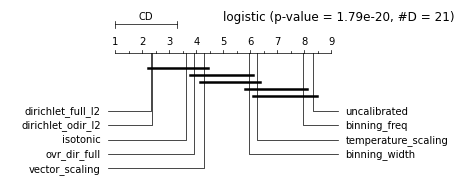

In [15]:
from pycalib.stats import plot_critical_difference

_ = plot_critical_difference(avranks=ranking_table,
                           num_datasets=table.shape[0],
                           names=table.columns.levels[1],
                           title='{} (p-value = {:.2e}, #D = {})'.format(classifier_name, 
                                                                        ftest.pvalue, table.shape[0]))

We also show the number of test attempts (datasets) and the Friedman test p-value on the right.

# Datasets and classifiers combinations

However, we collected results for multiple classifiers and datasets. We will combine all the results in order to perform the final comparison. In this case the $k$ treatments will be the calibrators, and the $n$ test attempts will be all the combinations between classifiers and datasets.

We will select now another metric.

In [16]:
metric = 'loss'
max_is_better = False

Create a table with all the measurements

In [17]:
table = df_results.pivot_table(index=['dataset', 'classifier'],
                       columns=['method'],
                       values=[measure], aggfunc=np.mean)

table

brier                                  \
method             binning_freq binning_width dirichlet_full_l2   
dataset classifier                                                
abalone adas           0.178855      0.182385          0.181421   
        forest         0.173903      0.173532          0.172031   
        knn            0.186166      0.186154          0.186203   
        lda            0.178308      0.178273          0.177680   
        logistic       0.176019      0.175924          0.174878   
...                         ...           ...               ...   
yeast   nbayes         0.062801      0.068796          0.059578   
        qda            0.057914      0.055707          0.054833   
        svc-linear     0.056781      0.054578          0.054435   
        svc-rbf        0.060456      0.059695          0.059313   
        tree           0.057649      0.057065          0.057791   

                                                             \
method             dirichlet_odir_l2  isotonic ovr_dir_full   
dataset classifier                                            
abalone adas                0.180939  0.178349     0.186005   
        forest              0.172288  0.173068     0.173044   
        knn                 0.191166  0.186072     0.194483   
        lda                 0.177691  0.178307     0.177923   
        logistic            0.174878  0.175860     0.175690   
...                              ...       ...          ...   
yeast   nbayes              0.055537  0.059693     0.062768   
        qda                 0.055781  0.055090     0.056148   
        svc-linear          0.054043  0.054066     0.053980   
        svc-rbf             0.059346  0.058109     0.059405   
        tree                0.057018  0.056623     0.056837   

                                                                    
method             temperature_scaling uncalibrated vector_scaling  
dataset classifier                                                  
abalone adas                  0.186849     0.218857       0.183716  
        forest                0.174117     0.174278       0.172250  
        knn                   0.196887     0.201453       0.183671  
        lda                   0.178152     0.178201       0.177809  
        logistic              0.176273     0.176536       0.176380  
...                                ...          ...            ...  
yeast   nbayes                0.085419     0.115265       0.057843  
        qda                   0.059998     0.057946       0.056293  
        svc-linear            0.054346     0.054744       0.054044  
        svc-rbf               0.059794     0.060247       0.059474  
        tree                  0.056422     0.056389       0.056708  

[229 rows x 9 columns]

Remove any combination of dataset and classifier which had at least one of the calibration results missing

In [18]:
table = table[~table.isna().any(axis=1)]

Change the order of the values if the maximum is a better result

In [19]:
if max_is_better:
    table *= -1

In [20]:
ftest = compute_friedmanchisquare(table)
print('Friedman test on the full table of shape {}'.format(
            np.shape(table)))
print(ftest)

Friedman test on the full table of shape (229, 9)
FriedmanchisquareResult(statistic=645.5841915644676, pvalue=3.6798823197721567e-134)


We can now obtain the average rankings for all the calibrators

In [21]:
ranking_table_all = table.apply(rankdata, axis=1).mean()
ranking_table_all

array([7.4 , 6.32, 3.88, 3.13, 3.85, 3.9 , 5.97, 6.9 , 3.65])

And finally plot the critical difference diagram

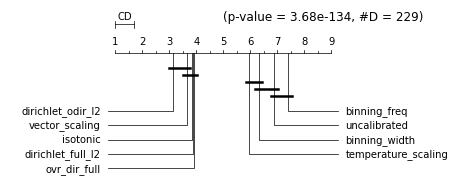

In [22]:
_ = plot_critical_difference(avranks=ranking_table_all,
                           num_datasets=len(table),
                           names=table.columns.levels[1],
                           title='(p-value = {:.2e}, #D = {})'.format(ftest.pvalue, len(table)))

# Summary to compare calibration methods

In order to compare several calibration methods we will use 

- Select D datasets
- Select C base classifiers
- Select M calibration methods

The M calibration methods will be compared in all DxC combinations

For each pair (M, DxC) we will run several repetitions in order to get better estimates.

- Repeat N times the following process:
- 5-fold cross-validation to divide the random shuffle into train and test
- The train partition will be further divided with 3-fold cross-validation to train and validate the classifier + calibrator combination

The previous process will generate Nx5 evaluation estimations

Finally, the M calibrators with the Nx5 estimations for each DxC combination are compared in the following manner.

1. We rank the M calibrators and perform a Friedman test to get the statistical difference.
2. If the p-value of the test is under 0.005 we performed a post-hoc one-tailed Bonferroni-Dunn test to obtain Critical Differences which indicate the minimum ranking difference to consider the methods significantly different.